In [1]:
# ============================================================
#  CELL 1 — Environment Check & Imports
# ============================================================
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Check that we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# If this prints 'cuda', you're good.
# If it prints 'cpu', go to Runtime → Change Runtime Type → GPU

Using device: cuda
PyTorch version: 2.9.0+cu128


In [2]:
# ============================================================
#  CELL 2 — Understanding Tensors
# ============================================================

# A fake grayscale image: 1 channel, 4x4 pixels
grayscale = torch.rand(1, 4, 4)   # values between 0 and 1
print("Shape:", grayscale.shape)   # torch.Size([1, 4, 4])
print("Values:\n", grayscale)

# A fake batch of 8 grayscale images at 64x64
batch = torch.rand(8, 1, 64, 64)
print("\nBatch shape:", batch.shape)  # [batch, channels, height, width]

# This is the shape our model will receive as input ☝️

Shape: torch.Size([1, 4, 4])
Values:
 tensor([[[0.0894, 0.9826, 0.6436, 0.8929],
         [0.0199, 0.1392, 0.3726, 0.6089],
         [0.0140, 0.3607, 0.2344, 0.9917],
         [0.1838, 0.0260, 0.0684, 0.5666]]])

Batch shape: torch.Size([8, 1, 64, 64])


In [3]:
# ============================================================
#  CELL 3 — How a Conv Layer Works
# ============================================================

# One Conv layer: takes 1 input channel, produces 16 feature maps,
# using a 3x3 filter, with padding to keep the spatial size the same
conv = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)

# Pass our batch through it
output = conv(batch)
print("Input shape: ", batch.shape)   # [8, 1,  64, 64]
print("Output shape:", output.shape)  # [8, 16, 64, 64]

# Notice: same spatial size (64x64), but now 16 feature maps
# Each map has learned to detect something different

Input shape:  torch.Size([8, 1, 64, 64])
Output shape: torch.Size([8, 16, 64, 64])


In [4]:
# ============================================================
#  CELL 4 — The Building Block: ConvBlock
# ============================================================

import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    """
    A reusable building block: Conv → BatchNorm → ReLU

    We stack many of these to build the encoder and decoder.
    Think of it as one "layer of understanding."
    """
    def __init__(self, in_channels, out_channels, stride=1):
        """
        in_channels  : how many feature maps are coming IN
        out_channels : how many feature maps we want coming OUT
        stride       : controls downsampling. stride=1 → same size.
                       stride=2 → halves spatial dimensions (used in encoder)
        """
        super(ConvBlock, self).__init__()
        # ── nn.Module ──────────────────────────────────────────────────
        # Every custom PyTorch model must inherit from nn.Module.
        # super().__init__() initializes the parent class internals —
        # it sets up the machinery that tracks parameters, enables
        # .to(device), .train()/.eval() modes, etc. Always required.

        self.block = nn.Sequential(
            # ── nn.Sequential ──────────────────────────────────────────
            # A container that runs layers one after another.
            # output of layer 1 → input of layer 2 → input of layer 3.
            # Makes the forward pass clean: just call self.block(x).

            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,   # 3×3 filter — standard choice, captures
                                 # local neighborhood without being too large
                stride=stride,   # stride=2 means the filter jumps 2 pixels
                                 # at a time → output is half the input size
                padding=1,       # adds 1 pixel border of zeros around input.
                                 # Without this, each Conv shrinks the image
                                 # slightly. padding=1 with kernel=3 keeps
                                 # spatial size the same when stride=1.
                bias=False       # We set bias=False because BatchNorm
                                 # (next layer) has its own bias term (beta).
                                 # Having both is redundant.
            ),

            nn.BatchNorm2d(out_channels),
            # ── BatchNorm2d ────────────────────────────────────────────
            # After convolution, values can be wildly different scales.
            # Large values → unstable gradients → training fails.
            # BatchNorm normalizes each feature map across the batch to
            # have mean≈0 and std≈1, then applies learnable scale (gamma)
            # and shift (beta). This keeps training stable and lets us
            # use higher learning rates. The '2d' means it works on
            # 2D feature maps (as opposed to BatchNorm1d for vectors).

            nn.ReLU(inplace=True),
            # ── ReLU (Rectified Linear Unit) ──────────────────────────
            # The activation function. Formula: f(x) = max(0, x)
            # Without activations, stacking Conv layers is mathematically
            # equivalent to just ONE layer (they'd all collapse into one
            # linear transformation). Non-linearity is what gives neural
            # networks their power to model complex mappings.
            # inplace=True modifies the tensor in memory rather than
            # creating a new one — saves a bit of memory.
        )

    def forward(self, x):
        # ── forward() ──────────────────────────────────────────────────
        # Defines what happens when data passes through this block.
        # PyTorch calls this automatically when you do block(x).
        # 'x' is the input tensor. We just pass it through self.block.
        return self.block(x)


# Quick test
dummy = torch.rand(4, 1, 64, 64)        # batch=4, channels=1, 64×64
block = ConvBlock(in_channels=1, out_channels=32, stride=1)
out = block(dummy)
print(f"Input:  {dummy.shape}")          # [4, 1,  64, 64]
print(f"Output: {out.shape}")            # [4, 32, 64, 64]  ← more channels, same size

Input:  torch.Size([4, 1, 64, 64])
Output: torch.Size([4, 32, 64, 64])


In [5]:
# ============================================================
#  CELL 5 (FIXED v2) — DecoderBlock with explicit skip_channels
# ============================================================

class DecoderBlock(nn.Module):
    """
    in_channels   : channels coming into this decoder block (from below)
    skip_channels : channels from the encoder skip connection
    out_channels  : channels we want to output

    After cat: total input to conv = in_channels + skip_channels
    """
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            in_channels, in_channels,
            kernel_size=2, stride=2
        )

        # ── in_channels + skip_channels ───────────────────────────────
        # No longer blindly multiplying by 2.
        # We explicitly tell the conv how many channels to expect
        # after the cat — which is the sum of both inputs.
        self.conv = ConvBlock(in_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)

        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(
                x, size=skip.shape[2:],
                mode='bilinear', align_corners=False
            )

        x = torch.cat([x, skip], dim=1)  # channels: in + skip
        return self.conv(x)

In [6]:
# ============================================================
#  CELL 6 (FIXED v3) — ColorizationNet for 128×128
# ============================================================

class ColorizationNet(nn.Module):
    """
    Same U-Net architecture, scaled for 128×128 input.

    Spatial flow:
      enc1: 128→128  (stride=1, full res skip)
      pool: 128→64
      enc2:  64→64
      pool:  64→32
      enc3:  32→32
      pool:  32→16
      enc4:  16→16
      pool:  16→8
      bottleneck: 8→8
      dec4:  8→16
      dec3: 16→32
      dec2: 32→64
      dec1: 64→128  ← back to full res
    """
    def __init__(self):
        super(ColorizationNet, self).__init__()

        # ENCODER
        self.enc1 = ConvBlock(1,   64,  stride=1)
        self.enc2 = ConvBlock(64,  128, stride=1)
        self.enc3 = ConvBlock(128, 256, stride=1)
        self.enc4 = ConvBlock(256, 512, stride=1)
        self.pool = nn.MaxPool2d(2, 2)

        # BOTTLENECK
        self.bottleneck = ConvBlock(512, 512, stride=1)
        # ── Reduced bottleneck channels ───────────────────────────────
        # At 128×128 input the bottleneck spatial size is only 8×8.
        # Keeping 512 (not 1024) channels is plenty of capacity at
        # that resolution, and saves GPU memory + trains faster.

        # DECODER — (in_channels, skip_channels, out_channels)
        self.dec4 = DecoderBlock(512, 512, 256)
        self.dec3 = DecoderBlock(256, 256, 128)
        self.dec2 = DecoderBlock(128, 128,  64)
        self.dec1 = DecoderBlock( 64,  64,  32)

        # OUTPUT
        self.output_conv = nn.Conv2d(32, 2, kernel_size=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        e1 = self.enc1(x)                  # [B,  64, 128, 128]
        e2 = self.enc2(self.pool(e1))      # [B, 128,  64,  64]
        e3 = self.enc3(self.pool(e2))      # [B, 256,  32,  32]
        e4 = self.enc4(self.pool(e3))      # [B, 512,  16,  16]
        b  = self.bottleneck(self.pool(e4))# [B, 512,   8,   8]

        d4 = self.dec4(b,  e4)             # [B, 256,  16,  16]
        d3 = self.dec3(d4, e3)             # [B, 128,  32,  32]
        d2 = self.dec2(d3, e2)             # [B,  64,  64,  64]
        d1 = self.dec1(d2, e1)             # [B,  32, 128, 128]

        return self.tanh(self.output_conv(d1))  # [B, 2, 128, 128]


# Rebuild model
model = ColorizationNet().to(device)

# Sanity check
dummy = torch.rand(4, 1, 128, 128).to(device)
with torch.no_grad():
    out = model(dummy)

assert out.shape == torch.Size([4, 2, 128, 128])
print(f"✅ Output shape: {out.shape}")
print(f"   Parameters:  {sum(p.numel() for p in model.parameters()):,}")


✅ Output shape: torch.Size([4, 2, 128, 128])
   Parameters:  8,439,170


In [7]:
# ============================================================
#  CELL 7 — Sanity Check
# ============================================================

# Create a fake grayscale image batch
dummy_input = torch.rand(4, 1, 256, 256).to(device)

# Forward pass — no training yet, just checking shapes
with torch.no_grad():
    # ── torch.no_grad() ───────────────────────────────────────────────
    # Tells PyTorch: don't track gradients for this operation.
    # We're just testing, not training, so there's no need to build
    # the computation graph. Saves memory and runs faster.
    output = model(dummy_input)

print(f"Input shape:  {dummy_input.shape}")   # [4, 1,  256, 256]
print(f"Output shape: {output.shape}")         # [4, 2,  256, 256]
print(f"Output range: {output.min():.2f} to {output.max():.2f}")  # should be in (-1, 1)

print("\n✅ Model architecture is working correctly!")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
# ── .numel() ──────────────────────────────────────────────────────────
# Returns the total number of elements in a tensor.
# We sum this across all parameter tensors to get total model params.

Input shape:  torch.Size([4, 1, 256, 256])
Output shape: torch.Size([4, 2, 256, 256])
Output range: -0.92 to 0.98

✅ Model architecture is working correctly!
   Total parameters: 8,439,170


In [8]:
# ============================================================
#  CELL 8 — Color Space Utilities
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
# ── scikit-image (skimage) ────────────────────────────────────────────
# A Python library for image processing. We use it purely for one thing:
# converting between RGB and LAB color spaces. It handles all the
# complex math (gamma correction, white point normalization, etc.)
# so we don't have to implement it ourselves.

def rgb_to_lab(img_rgb_np):
    """
    Convert a numpy RGB image to LAB.

    Input:  np.array of shape (H, W, 3), values in [0, 1]  ← float, not 0-255
    Output: np.array of shape (H, W, 3)
            L in [0, 100], a in [-128, 127], b in [-128, 127]
    """
    return color.rgb2lab(img_rgb_np)
    # ── color.rgb2lab ─────────────────────────────────────────────────
    # skimage's RGB→LAB converter. Expects float input in [0,1].
    # Internally it goes RGB → XYZ → LAB (two-step transformation).
    # The math involves the D65 illuminant standard (daylight white point)
    # but we don't need to worry about that — skimage handles it.

def lab_to_rgb(img_lab_np):
    """
    Convert a LAB numpy image back to RGB for display.

    Input:  np.array (H, W, 3) in LAB ranges
    Output: np.array (H, W, 3) in [0, 1] RGB, clipped for display
    """
    rgb = color.lab2rgb(img_lab_np)
    return np.clip(rgb, 0, 1)
    # ── np.clip ───────────────────────────────────────────────────────
    # Clamps all values to [0, 1]. The LAB→RGB conversion can sometimes
    # produce tiny values like -0.001 or 1.002 due to floating point math.
    # clip() prevents these from causing display issues.

def preprocess_lab(img_rgb_np):
    """
    Full pipeline: RGB numpy image → normalized L, ab tensors.

    We normalize to make training stable:
      L:  [0, 100]    → [-1,  1]   (divide by 50, subtract 1)
      ab: [-128, 127] → [-1,  1]   (divide by 128)

    Why normalize? Neural networks learn best when inputs and targets
    are in a consistent, small range. Raw LAB values vary wildly.
    Normalizing to [-1,1] matches our Tanh output range exactly.
    """
    lab = rgb_to_lab(img_rgb_np)             # (H, W, 3)

    L  = lab[:, :, 0]                        # (H, W) — lightness
    ab = lab[:, :, 1:]                       # (H, W, 2) — color channels

    # Normalize L to [-1, 1]
    L_norm = (L / 50.0) - 1.0

    # Normalize ab to [-1, 1]
    ab_norm = ab / 128.0

    # Convert to tensors and add channel dimension
    # ── torch.from_numpy ──────────────────────────────────────────────
    # Converts a numpy array to a PyTorch tensor. They share memory,
    # so no copying happens — it's very efficient.
    # .float() ensures dtype is float32 (PyTorch's default for networks).
    L_tensor  = torch.from_numpy(L_norm).float().unsqueeze(0)
    # ── .unsqueeze(0) ─────────────────────────────────────────────────
    # Adds a dimension at position 0.
    # (H, W) → (1, H, W) — adds the channel dimension PyTorch expects.

    ab_tensor = torch.from_numpy(ab_norm).float().permute(2, 0, 1)
    # ── .permute(2, 0, 1) ─────────────────────────────────────────────
    # Reorders dimensions. numpy is (H, W, C), PyTorch wants (C, H, W).
    # permute(2,0,1) means: new_dim0=old_dim2, new_dim1=old_dim0, new_dim2=old_dim1
    # (H,W,2) → (2,H,W)

    return L_tensor, ab_tensor


def postprocess_lab(L_tensor, ab_tensor):
    """
    Convert normalized model output back to a displayable RGB image.
    Used during evaluation to visualize what the model predicted.

    Input:  L_tensor  (1, H, W) in [-1, 1]
            ab_tensor (2, H, W) in [-1, 1]
    Output: np.array  (H, W, 3) RGB in [0, 1]
    """
    # Denormalize — reverse the normalization we applied above
    L  = (L_tensor.squeeze().numpy()  + 1.0) * 50.0   # [-1,1] → [0,100]
    ab = ab_tensor.permute(1, 2, 0).numpy() * 128.0   # [-1,1] → [-128,127]

    # Stack back into (H, W, 3) LAB image
    lab = np.concatenate([L[:, :, np.newaxis], ab], axis=2)
    # ── np.newaxis ────────────────────────────────────────────────────
    # Adds a new axis, like unsqueeze for numpy.
    # L is (H,W), we need (H,W,1) to concatenate with ab (H,W,2).

    return lab_to_rgb(lab)


# ── Quick visual sanity check ─────────────────────────────────────────
# Download one test image to verify the pipeline works end-to-end
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as T

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/PNG_transparency_demonstration_1.png/280px-PNG_transparency_demonstration_1.png"

# Use a simple solid-color test instead — no internet needed in Colab
test_rgb = np.random.rand(64, 64, 3).astype(np.float32)  # fake image

L_t, ab_t = preprocess_lab(test_rgb)
reconstructed = postprocess_lab(L_t, ab_t)

print(f"L tensor shape:  {L_t.shape}")        # (1, 64, 64)
print(f"ab tensor shape: {ab_t.shape}")       # (2, 64, 64)
print(f"L range:  {L_t.min():.2f} to {L_t.max():.2f}")   # ~(-1, 1)
print(f"ab range: {ab_t.min():.2f} to {ab_t.max():.2f}") # ~(-1, 1)
print(f"Reconstructed shape: {reconstructed.shape}")       # (64, 64, 3)
print("\n✅ LAB pipeline working!")

L tensor shape:  torch.Size([1, 64, 64])
ab tensor shape: torch.Size([2, 64, 64])
L range:  -0.97 to 0.95
ab range: -0.83 to 0.76
Reconstructed shape: (64, 64, 3)

✅ LAB pipeline working!


In [10]:
# ============================================================
#  CELL 9 (FIXED v3) — STL-10 Dataset with imports
# ============================================================
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
# ── These three imports are what Cell 9 needs ─────────────────────────
# Dataset   → base class for our ColorizationDataset
# DataLoader → wraps dataset into iterable batches
# torchvision → provides STL10 dataset and transforms
# We re-state them here so this cell is self-contained and can be
# run independently without relying on imports from other cells.

class ColorizationDataset(Dataset):
    def __init__(self, root, split='train', size=128, max_samples=None):
        self.size = size

        raw = torchvision.datasets.STL10(
            root=root,
            split=split,
            download=True,
            transform=T.Compose([
                T.Resize((size, size), antialias=True),
                T.ToTensor()
            ])
        )

        n = max_samples or len(raw)
        indices = list(range(min(n, len(raw))))

        print(f"  Pre-caching {len(indices)} images...", end=" ")
        self.cache = []
        for i in indices:
            img_tensor, _ = raw[i]
            img_np = img_tensor.permute(1, 2, 0).numpy()
            L, ab  = preprocess_lab(img_np)
            self.cache.append((L, ab))
        print("done ✅")

    def __len__(self):
        return len(self.cache)

    def __getitem__(self, idx):
        return self.cache[idx]


print("Building training dataset (STL-10):")
train_dataset = ColorizationDataset(
    root='/content/data', split='train',
    size=128, max_samples=4000
)

print("Building validation dataset (STL-10):")
val_dataset = ColorizationDataset(
    root='/content/data', split='test',
    size=128, max_samples=800
)

train_loader = DataLoader(
    train_dataset, batch_size=32,
    shuffle=True, num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=32,
    shuffle=False, num_workers=2, pin_memory=True
)

print(f"\nTrain: {len(train_dataset):,} samples, {len(train_loader)} batches")
print(f"Val:   {len(val_dataset):,} samples, {len(val_loader)} batches")

L_batch, ab_batch = next(iter(train_loader))
print(f"\nL  batch: {L_batch.shape}")
print(f"ab batch: {ab_batch.shape}")

Building training dataset (STL-10):
  Pre-caching 4000 images... done ✅
Building validation dataset (STL-10):
  Pre-caching 800 images... done ✅

Train: 4,000 samples, 125 batches
Val:   800 samples, 25 batches

L  batch: torch.Size([32, 1, 128, 128])
ab batch: torch.Size([32, 2, 128, 128])


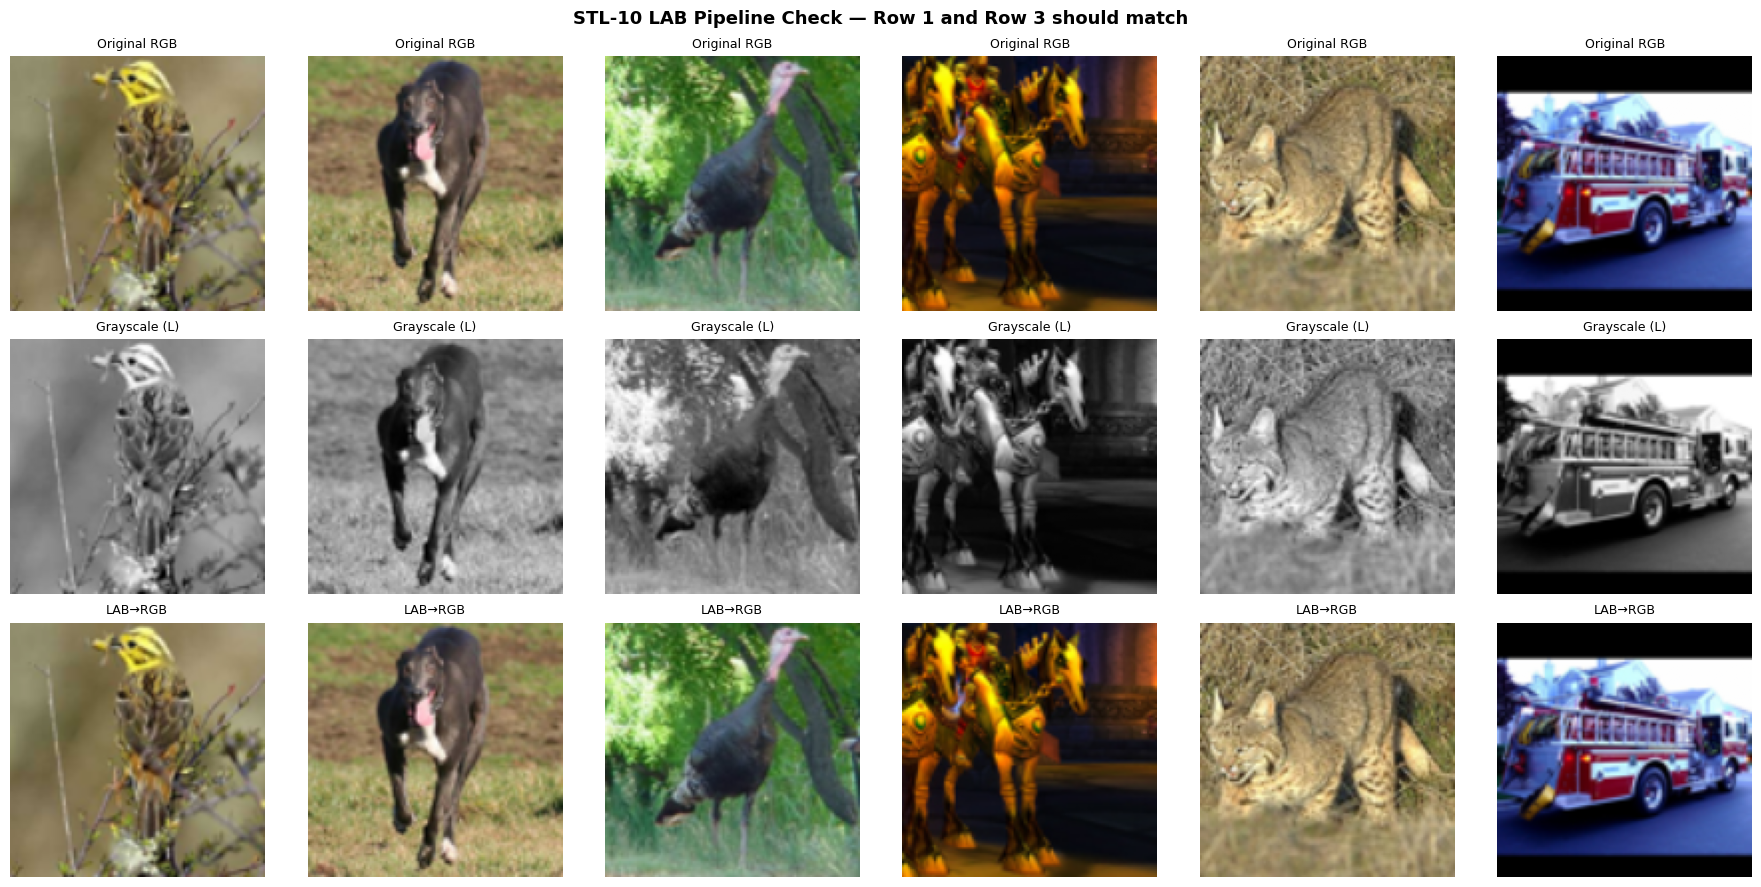

✅ Pipeline check complete!


In [11]:
# ============================================================
#  CELL 10 (FIXED v4) — Visualize STL-10 pipeline
# ============================================================

raw_viz = torchvision.datasets.STL10(
    root='/content/data',
    split='train',
    download=False,        # already downloaded in Cell 9
    transform=T.Compose([
        T.Resize((128, 128), antialias=True),
        T.ToTensor()
    ])
)

fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for i in range(6):
    original_tensor, _ = raw_viz[i]
    original_np = original_tensor.permute(1, 2, 0).numpy()  # (128,128,3)

    L, ab = train_dataset.cache[i]
    gray     = (L.squeeze().numpy() + 1.0) / 2.0
    rec_rgb  = postprocess_lab(L, ab)

    axes[0, i].imshow(original_np)
    axes[0, i].set_title("Original RGB", fontsize=9)
    axes[0, i].axis('off')

    axes[1, i].imshow(gray, cmap='gray')
    axes[1, i].set_title("Grayscale (L)", fontsize=9)
    axes[1, i].axis('off')

    axes[2, i].imshow(rec_rgb)
    axes[2, i].set_title("LAB→RGB", fontsize=9)
    axes[2, i].axis('off')

plt.suptitle(
    "STL-10 LAB Pipeline Check — Row 1 and Row 3 should match",
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.show()
print("✅ Pipeline check complete!")

In [13]:
# ============================================================
#  CELL 11 (FIXED v2) — Loss + Optimizer
# ============================================================

class ColorizationLoss(nn.Module):
    def __init__(self, sat_weight=0.5):
        super(ColorizationLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.sat_weight = sat_weight

    def forward(self, pred_ab, true_ab):
        # MSE term — match colors accurately
        mse_loss = self.mse(pred_ab, true_ab)

        # Saturation term — reward colorful predictions
        pred_sat = torch.sqrt(pred_ab[:, 0:1]**2 + pred_ab[:, 1:2]**2 + 1e-8)
        true_sat = torch.sqrt(true_ab[:, 0:1]**2 + true_ab[:, 1:2]**2 + 1e-8)
        sat_loss = self.mse(pred_sat, true_sat)

        total = mse_loss + self.sat_weight * sat_loss
        return total, mse_loss.item(), sat_loss.item()


criterion = ColorizationLoss(sat_weight=0.5)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=2e-4,
    weight_decay=1e-5
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

def get_current_lr(optimizer):
    return optimizer.param_groups[0]['lr']

print("✅ Loss, optimizer and scheduler ready")

✅ Loss, optimizer and scheduler ready


In [14]:
# ============================================================
#  CELL 12 — Visualization utility (run during training)
# ============================================================

def visualize_predictions(model, val_loader, device, num_images=4):
    """
    Show side-by-side: Grayscale | Model's colorization | Ground truth
    Called during training so we can SEE progress visually.
    """
    model.eval()
    # ── .eval() ───────────────────────────────────────────────────────
    # Switches model to evaluation mode. Two things change:
    # 1. BatchNorm uses running statistics instead of batch statistics
    # 2. Dropout (if any) is disabled
    # Always call .eval() before inference, .train() before training.

    with torch.no_grad():
        L_batch, ab_batch = next(iter(val_loader))
        L_batch  = L_batch[:num_images].to(device)
        ab_batch = ab_batch[:num_images].to(device)

        pred_ab = model(L_batch)   # model's color prediction

    fig, axes = plt.subplots(num_images, 3, figsize=(10, 3.5 * num_images))
    titles = ['Grayscale Input', 'Model Output', 'Ground Truth']

    for i in range(num_images):
        # Move tensors to CPU for numpy operations
        L_cpu      = L_batch[i].cpu()
        pred_ab_cpu = pred_ab[i].cpu()
        true_ab_cpu = ab_batch[i].cpu()

        gray          = (L_cpu.squeeze().numpy() + 1.0) / 2.0
        pred_rgb      = postprocess_lab(L_cpu, pred_ab_cpu)
        true_rgb      = postprocess_lab(L_cpu, true_ab_cpu)

        for j, (img, cmap) in enumerate(zip(
            [gray, pred_rgb, true_rgb],
            ['gray', None, None]
        )):
            axes[i, j].imshow(img, cmap=cmap)
            axes[i, j].axis('off')
            if i == 0:
                axes[i, j].set_title(titles[j], fontweight='bold')

    plt.suptitle("Colorization Progress", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

    model.train()
    # Switch back to training mode after visualization


# ── Loss tracking ────────────────────────────────────────────────────
train_losses = []
val_losses   = []
# Simple Python lists. We append the loss after each epoch and use
# them to plot the learning curve at the end.

✅ Loaded previous best weights — fine-tuning from here

  Training for 25 epochs on STL-10
  Batches per epoch: 125
Epoch [ 1/25] Total: 0.0152 (MSE: 0.0097 + Sat: 0.0109)  Val: 0.0156  LR: 2.00e-04 ← best saved
Epoch [ 2/25] Total: 0.0149 (MSE: 0.0095 + Sat: 0.0107)  Val: 0.0149  LR: 2.00e-04 ← best saved
Epoch [ 3/25] Total: 0.0147 (MSE: 0.0094 + Sat: 0.0106)  Val: 0.0147  LR: 2.00e-04 ← best saved
Epoch [ 4/25] Total: 0.0146 (MSE: 0.0094 + Sat: 0.0105)  Val: 0.0146  LR: 2.00e-04 ← best saved
Epoch [ 5/25] Total: 0.0145 (MSE: 0.0093 + Sat: 0.0104)  Val: 0.0147  LR: 2.00e-04


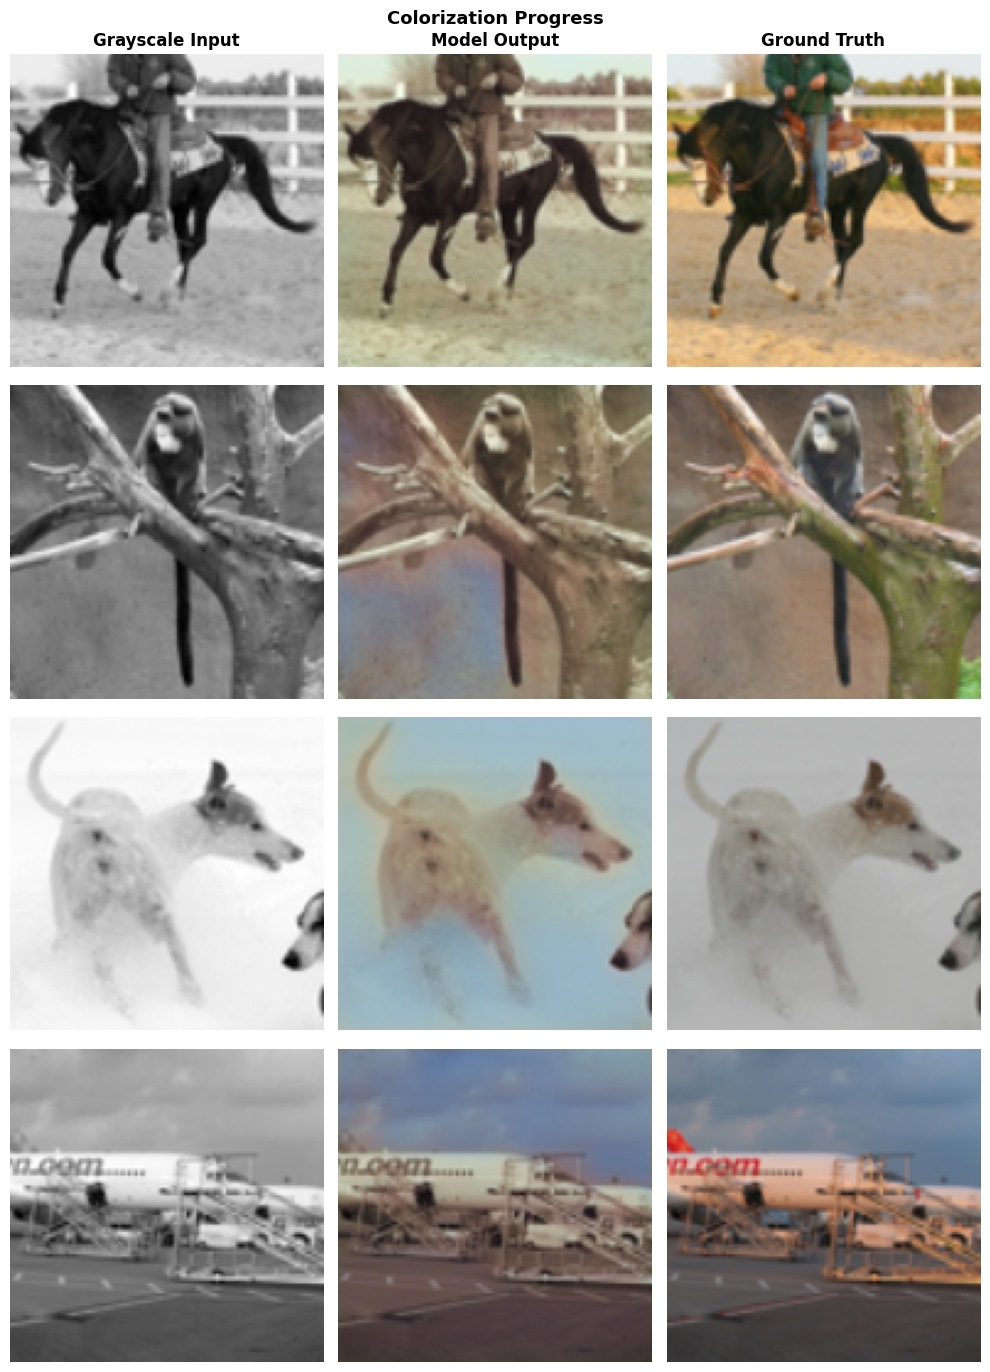

Epoch [ 6/25] Total: 0.0145 (MSE: 0.0092 + Sat: 0.0105)  Val: 0.0150  LR: 2.00e-04
Epoch [ 7/25] Total: 0.0146 (MSE: 0.0093 + Sat: 0.0105)  Val: 0.0147  LR: 2.00e-04
Epoch [ 8/25] Total: 0.0143 (MSE: 0.0092 + Sat: 0.0103)  Val: 0.0145  LR: 2.00e-04 ← best saved
Epoch [ 9/25] Total: 0.0144 (MSE: 0.0092 + Sat: 0.0104)  Val: 0.0148  LR: 2.00e-04
Epoch [10/25] Total: 0.0143 (MSE: 0.0091 + Sat: 0.0103)  Val: 0.0150  LR: 2.00e-04


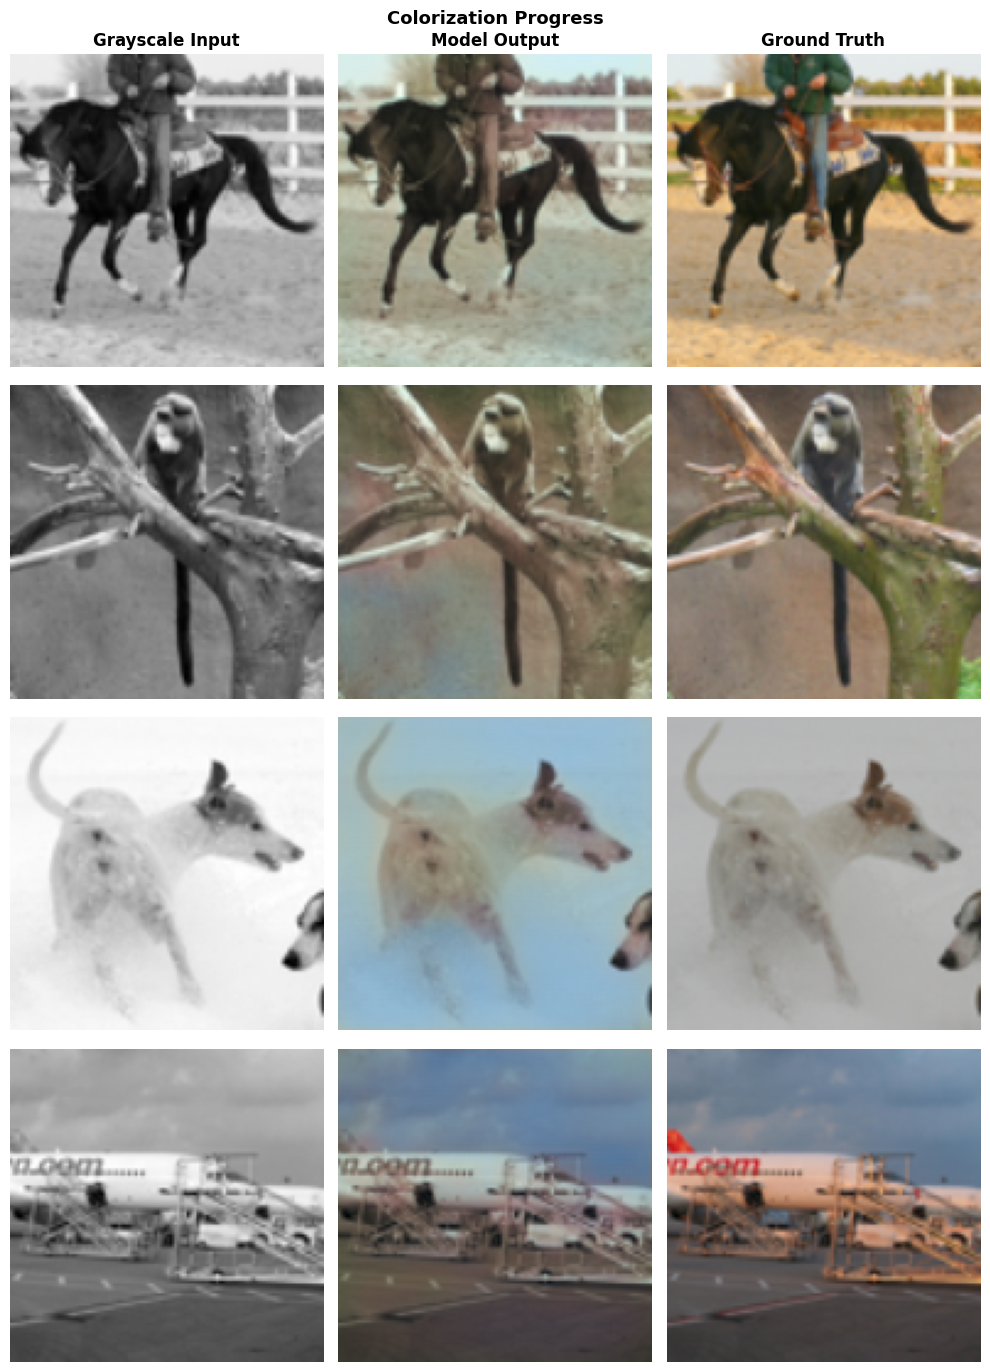

Epoch [11/25] Total: 0.0144 (MSE: 0.0092 + Sat: 0.0104)  Val: 0.0151  LR: 2.00e-04
Epoch [12/25] Total: 0.0143 (MSE: 0.0091 + Sat: 0.0103)  Val: 0.0144  LR: 2.00e-04 ← best saved
Epoch [13/25] Total: 0.0141 (MSE: 0.0090 + Sat: 0.0102)  Val: 0.0153  LR: 2.00e-04
Epoch [14/25] Total: 0.0142 (MSE: 0.0091 + Sat: 0.0102)  Val: 0.0143  LR: 2.00e-04 ← best saved
Epoch [15/25] Total: 0.0140 (MSE: 0.0090 + Sat: 0.0101)  Val: 0.0143  LR: 2.00e-04 ← best saved


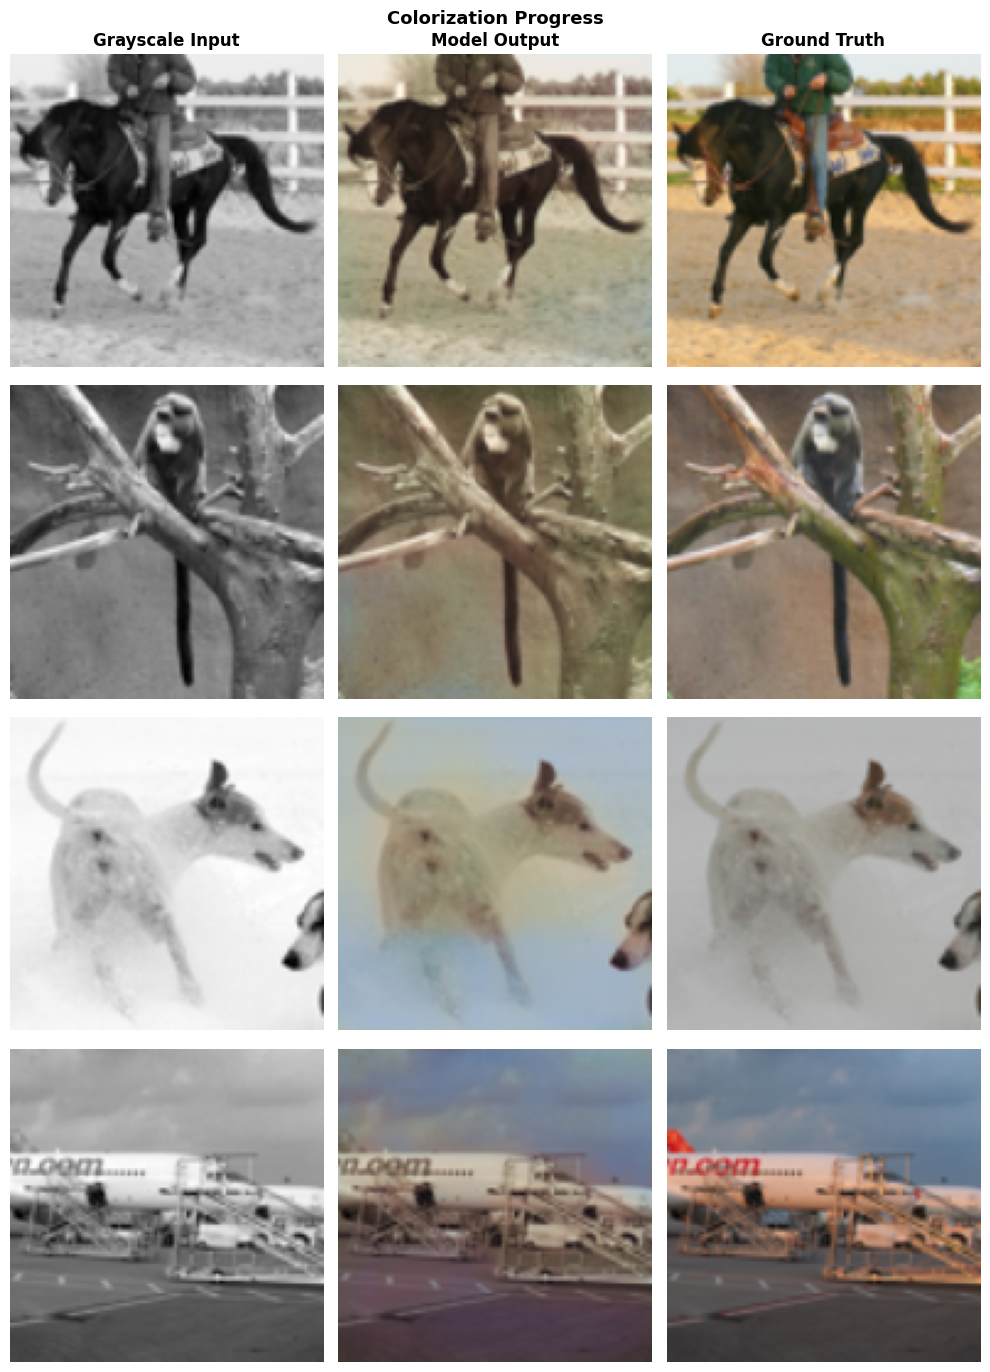

Epoch [16/25] Total: 0.0140 (MSE: 0.0089 + Sat: 0.0102)  Val: 0.0146  LR: 2.00e-04
Epoch [17/25] Total: 0.0140 (MSE: 0.0089 + Sat: 0.0102)  Val: 0.0144  LR: 2.00e-04
Epoch [18/25] Total: 0.0139 (MSE: 0.0089 + Sat: 0.0100)  Val: 0.0152  LR: 2.00e-04
Epoch [19/25] Total: 0.0139 (MSE: 0.0089 + Sat: 0.0101)  Val: 0.0143  LR: 2.00e-04 ← best saved
Epoch [20/25] Total: 0.0138 (MSE: 0.0088 + Sat: 0.0100)  Val: 0.0147  LR: 2.00e-04


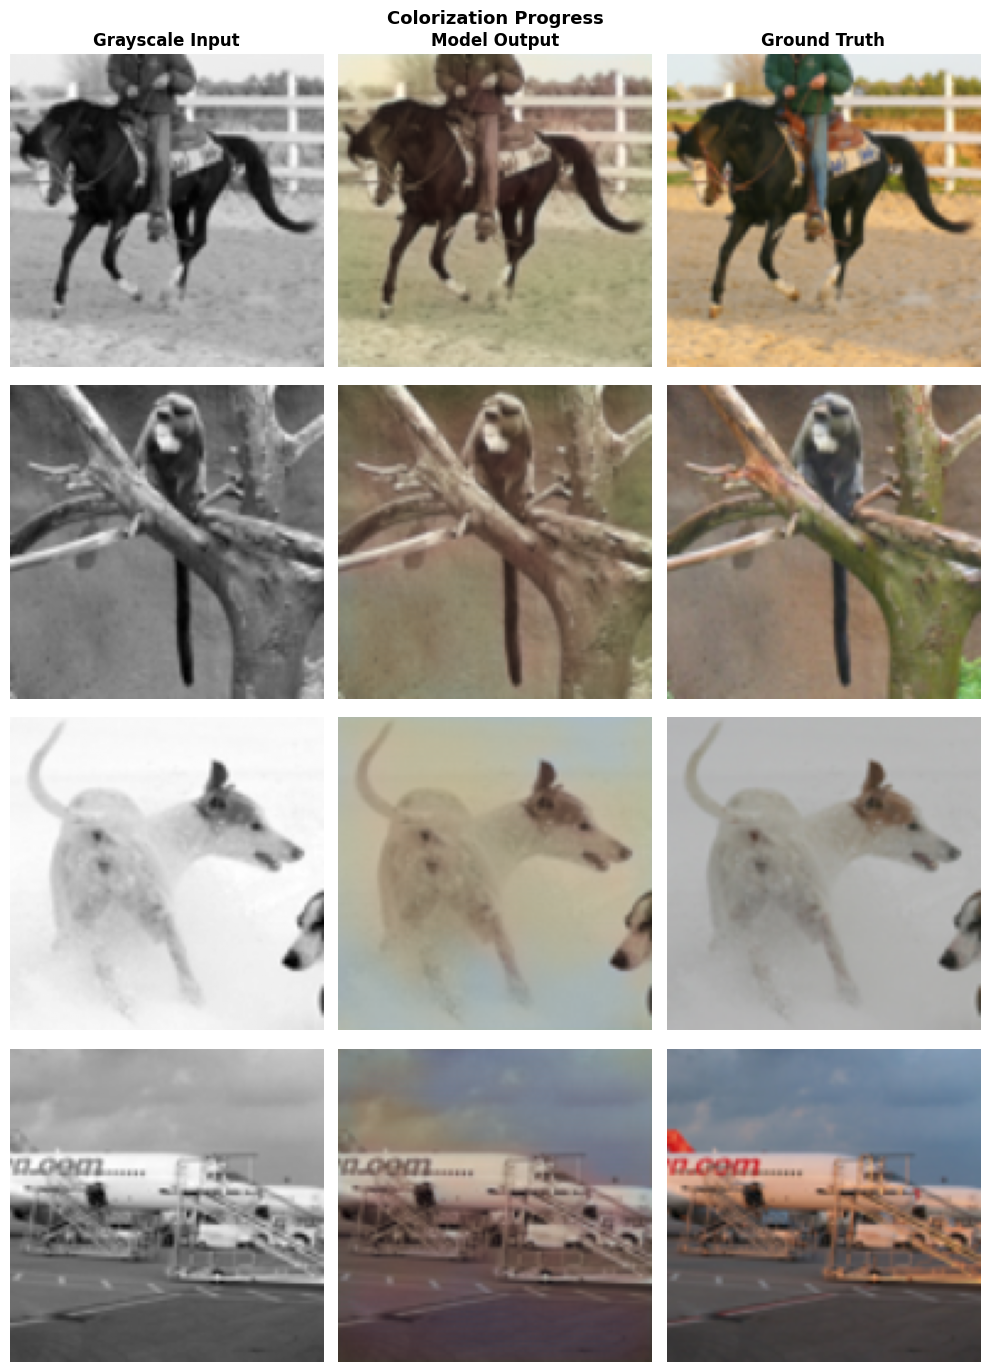

Epoch [21/25] Total: 0.0137 (MSE: 0.0087 + Sat: 0.0100)  Val: 0.0144  LR: 2.00e-04
Epoch [22/25] Total: 0.0136 (MSE: 0.0087 + Sat: 0.0099)  Val: 0.0144  LR: 2.00e-04
Epoch [23/25] Total: 0.0136 (MSE: 0.0086 + Sat: 0.0098)  Val: 0.0145  LR: 1.00e-04
Epoch [24/25] Total: 0.0131 (MSE: 0.0084 + Sat: 0.0095)  Val: 0.0141  LR: 1.00e-04 ← best saved
Epoch [25/25] Total: 0.0128 (MSE: 0.0082 + Sat: 0.0093)  Val: 0.0143  LR: 1.00e-04


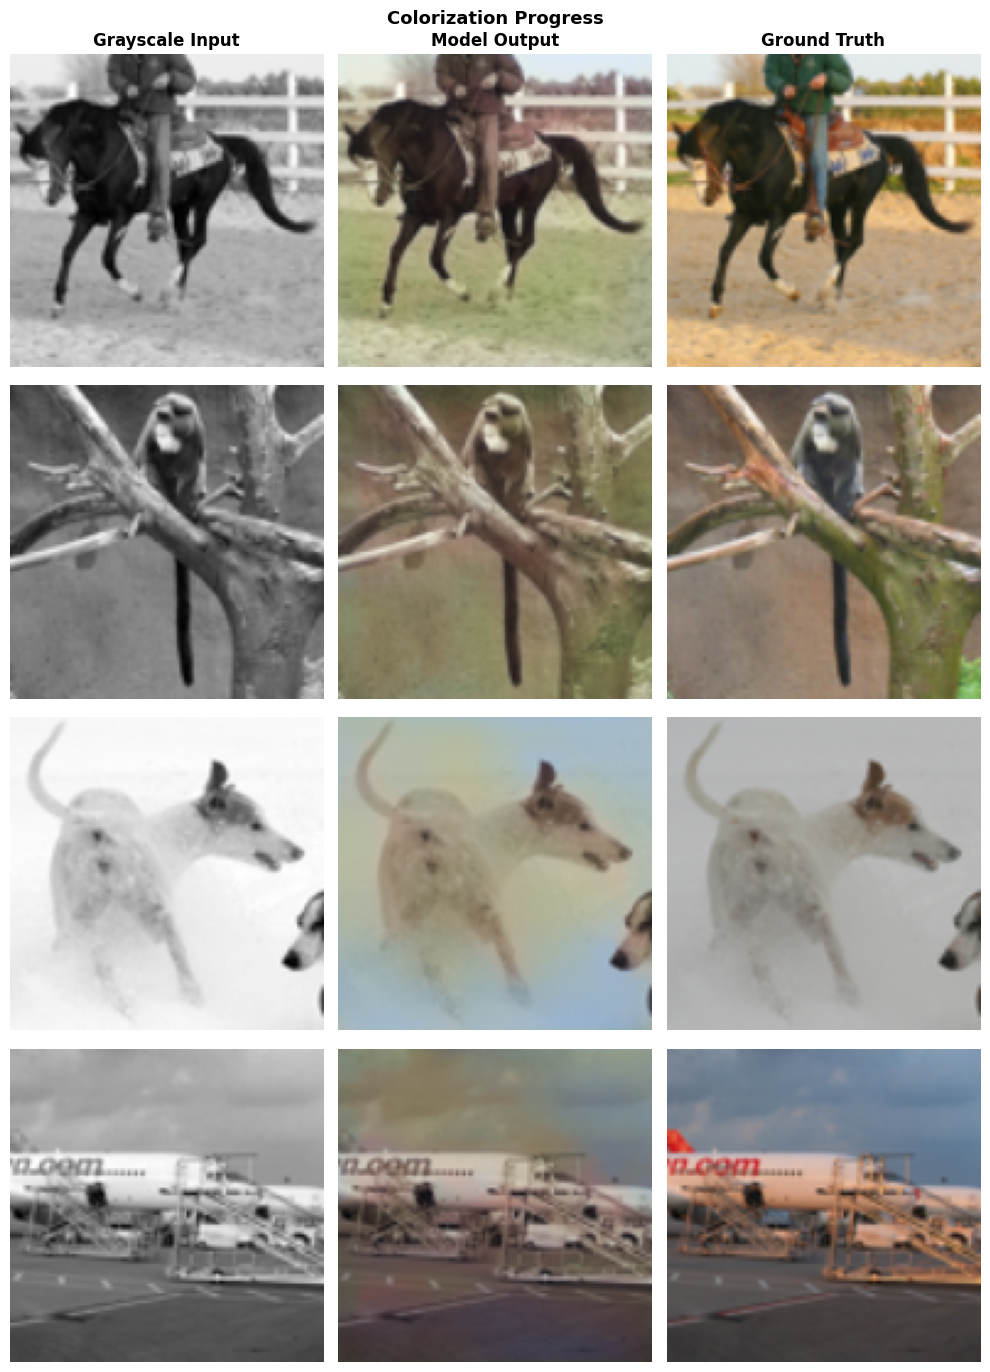


  Training complete! Best val loss: 0.0141


In [15]:
# ============================================================
#  CELL 13 (FIXED) — Training loop with new loss
# ============================================================

# Load the best weights from previous training as starting point
# ── Transfer learning ─────────────────────────────────────────────────
# Instead of starting from random weights, we load what the model
# already learned. Even though it only learned "brownish" colors,
# the encoder has learned useful edge and texture features.
# Fine-tuning from here is much faster than training from scratch.
try:
    model.load_state_dict(torch.load('/content/best_model.pth'))
    print("✅ Loaded previous best weights — fine-tuning from here")
except:
    print("⚠️  No saved weights found — training from scratch")

NUM_EPOCHS   = 25
best_val_loss = float('inf')
train_losses  = []
val_losses    = []

print(f"\n{'='*60}")
print(f"  Training for {NUM_EPOCHS} epochs on STL-10")
print(f"  Batches per epoch: {len(train_loader)}")
print(f"{'='*60}")

for epoch in range(NUM_EPOCHS):

    # ── TRAIN ─────────────────────────────────────────────────────────
    model.train()
    running_total = running_mse = running_sat = 0.0

    for L, ab in train_loader:
        L  = L.to(device)
        ab = ab.to(device)

        optimizer.zero_grad()
        pred_ab = model(L)

        loss, mse_val, sat_val = criterion(pred_ab, ab)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_total += loss.item()
        running_mse   += mse_val
        running_sat   += sat_val

    n = len(train_loader)
    avg_train = running_total / n

    # ── VALIDATE ──────────────────────────────────────────────────────
    model.eval()
    running_val = 0.0

    with torch.no_grad():
        for L, ab in val_loader:
            L  = L.to(device)
            ab = ab.to(device)
            pred_ab = model(L)
            loss, _, _ = criterion(pred_ab, ab)
            running_val += loss.item()

    avg_val = running_val / len(val_loader)

    train_losses.append(avg_train)
    val_losses.append(avg_val)
    scheduler.step(avg_val)

    # Save best
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), '/content/best_model.pth')
        saved = " ← best saved"
    else:
        saved = ""

    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] "
          f"Total: {avg_train:.4f} "
          f"(MSE: {running_mse/n:.4f} + Sat: {running_sat/n:.4f})  "
          f"Val: {avg_val:.4f}  "
          f"LR: {get_current_lr(optimizer):.2e}"
          f"{saved}")

    if (epoch + 1) % 5 == 0:
        visualize_predictions(model, val_loader, device)

print(f"\n{'='*60}")
print(f"  Training complete! Best val loss: {best_val_loss:.4f}")
print(f"{'='*60}")